In [1]:
# How do converted Finite Gaussian neural networks perform when making predictions over random noise?

In [2]:
from __future__ import print_function

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

import torch_helper_lib as th

In [4]:
# # random seeds
# torch.manual_seed(1665)
# np.random.seed(3266)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [6]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [7]:
# create random 28*28 images

# Random images dataset
x_rand = np.random.randint(low=0, high=255, size=(10000,28,28) )
#apply same transforms as for MNIST training
x_rand = x_rand/255.0
x_rand = (x_rand-0.1307)/0.3081

# print(np.mean(x_rand))
# print(np.std(x_rand))

x_rand = torch.Tensor(x_rand)


rand_dataset = torch.utils.data.TensorDataset(x_rand)# create your dataset
rand_dataloader = torch.utils.data.DataLoader(rand_dataset, 
                                              batch_size=32, 
                                              ) # create your dataloader

Shape: torch.Size([10000, 28, 28])
torch.Size([28, 28])


<IPython.core.display.Javascript object>


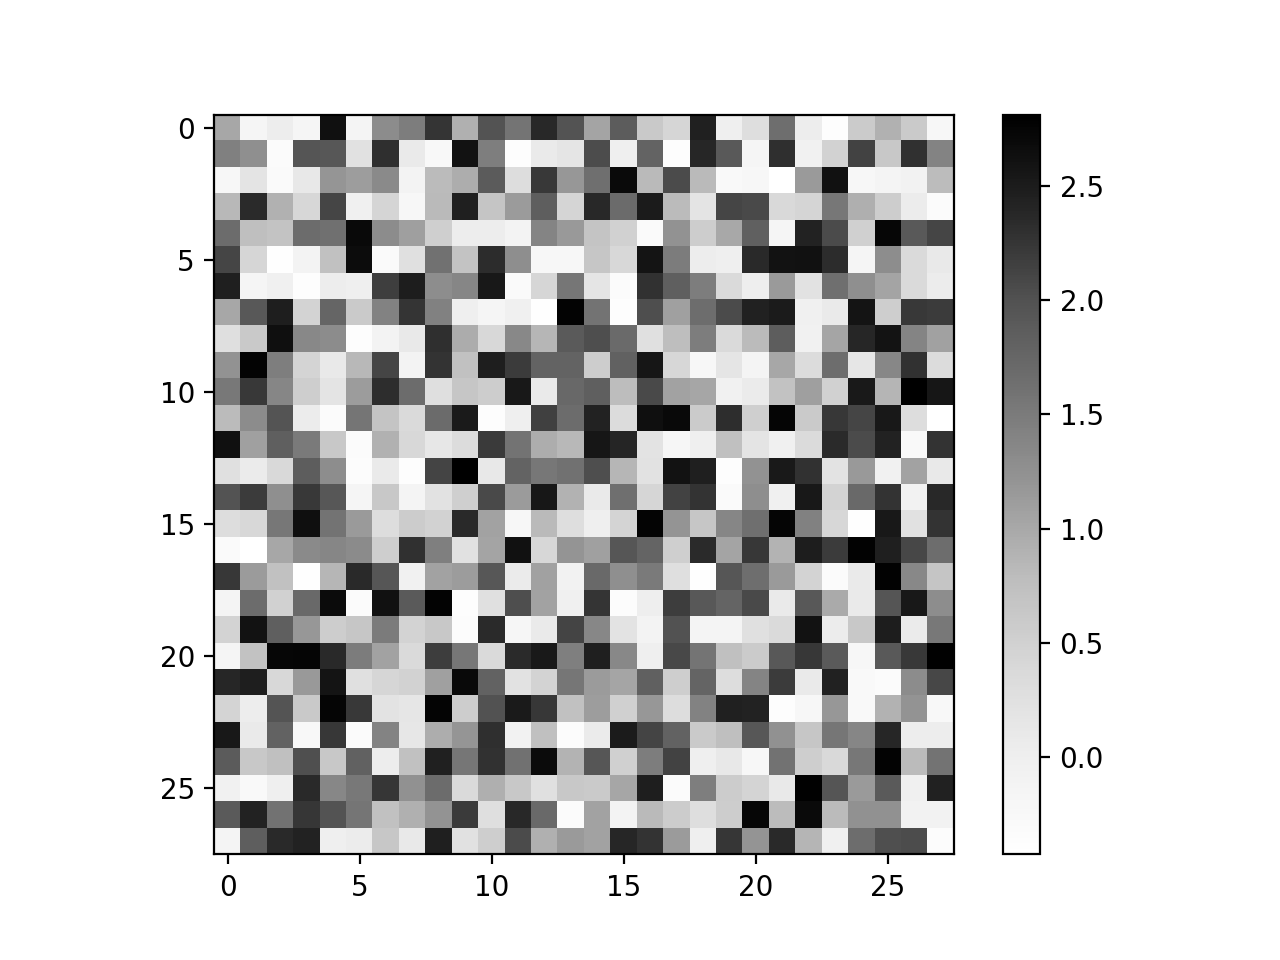

In [8]:
# show an example
print("Shape:", rand_dataloader.dataset.tensors[0].shape)
x = rand_dataloader.dataset.tensors[0][0]
print(x.shape)
# print("sample:", x)

plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

In [9]:
# pre-trained classic models 
model_dir = "./saved_models/Classic_MNIST_Net"
model_id = "./saved_models/Classic_MNIST_Net/model_[128, 128]"
exp_num = "_exp_0"
full_model = "_full.pth"
state_dict = "_state_dict.pth"

full_path = model_id+exp_num+full_model
dict_path = model_id+exp_num+state_dict
print(dict_path)

./saved_models/Classic_MNIST_Net/model_[128, 128]_exp_0_state_dict.pth


In [10]:
# dict load
classic_model = th.Classic_MNIST_Net(hidden_l_nums=[128,128])
classic_model.to(device)
classic_model.load_state_dict(torch.load(dict_path))

In [11]:
# create model to be converted
fgn_model = th.Feedforward_FGN_net(28*28,10,[128,128])

In [12]:
print(fgn_model.state_dict)

<bound method Feedforward_FGN_net.state_dict of Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): FGN_layer()
    (1): FGN_layer()
  )
  (fl): FGN_layer()
)>


In [13]:
from collections import OrderedDict 

In [14]:
# function that will convert state dicts 
def convert_state_dict_lin2FGN(lin_state_dict, fgn_state_dict):
    # given the state dict of a nn.Linear layer, and the fgn_state_dict (for the names)
    # returns a state dict for FGNlayer
    
    weights = lin_state_dict.values()[0]
    bias = lin_state_dict.values()[1]
    
    new_centers =  torch.Tensor([(-b/np.dot(x,x))*x for x,b in zip(weights.cpu().detach().numpy(), bias.cpu().detach().numpy())]) 
    
    fgn_state_dict[fgn_state_dict.keys()[0]] = weights
    fgn_state_dict[fgn_state_dict.keys()[1]] = new_centers
    fgn_state_dict[fgn_state_dict.keys()[2]] = 0.04*fgn_state_dict[fgn_state_dict.keys()[2]]
    
    return fgn_state_dict
    

In [15]:
def build_lin_layer_state_dicts(model_state_dict):
    # given a full model state dict, builds a list of state_dicts to be passed later to convert_...
    
    res_list = []
    next_sd = OrderedDict()
    # go through the model
    for key in model_state_dict:
        #check if weights
        if 'weight' in key:
            # add to next 
            next_sd.update({key: model_state_dict[key]})
        if 'bias' in key:
            # add to next
            next_sd.update({key: model_state_dict[key]})
            # add to res_list
            res_list.append(next_sd)
            # reset next
            next_sd = OrderedDict()
    
    return res_list

In [16]:
def build_fgn_layer_state_dicts(model_state_dict):
    # given a full fgn model state dict, builds a list of state_dicts to be passed later to convert_...
    
    res_list = []
    next_sd = OrderedDict()
    lin_state_dict = OrderedDict()
    # go through the model
    for key in model_state_dict:
        if 'weights' in key:
            # add to next 
            next_sd.update({key: model_state_dict[key]})
        if 'centers' in key:
            # add to next
            next_sd.update({key: model_state_dict[key]})
        if 'sigs' in key:
            # add to next
            next_sd.update({key: model_state_dict[key]})
        if 'pis' in key:
            # add to next
            next_sd.update({key: model_state_dict[key]})
            # add to res_list
            res_list.append(next_sd)
            # reset next
            next_sd = OrderedDict()
    
    return res_list

In [17]:
# convert the model
classic_list = build_lin_layer_state_dicts(classic_model.state_dict())
fgn_list = build_fgn_layer_state_dicts(fgn_model.state_dict())

new_state_dict = OrderedDict()
for c, f in zip (classic_list, fgn_list):
    new_state_dict.update(convert_state_dict_lin2FGN(c,f))

In [18]:
print(classic_model.state_dict().keys())

['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'fl.weight', 'fl.bias']


In [19]:
fgn_model.load_state_dict(new_state_dict)

In [20]:
fgn_model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): FGN_layer()
    (1): FGN_layer()
  )
  (fl): FGN_layer()
)

In [21]:
print(fgn_model.state_dict().keys())

['hidden_layers.0.weights', 'hidden_layers.0.centers', 'hidden_layers.0.sigs', 'hidden_layers.0.pis', 'hidden_layers.1.weights', 'hidden_layers.1.centers', 'hidden_layers.1.sigs', 'hidden_layers.1.pis', 'fl.weights', 'fl.centers', 'fl.sigs', 'fl.pis']


In [22]:
# apply model to data
# get predictions 
predictions = np.array([])
for data in rand_dataloader:
    data = data[0].to(device)
    pred,_ = fgn_model(data)
    pred = pred.cpu().detach().numpy()
    try:
        predictions = np.concatenate((predictions,pred))
    except:
        predictions=pred
        
# for some reason the networks make log_softmax predictions
predictions = np.exp(predictions)

In [23]:
# print first 5 pred
print(np.round(predictions[:5],decimals=2))
print("shape:", predictions.shape)

[[0.14 0.05 0.08 0.15 0.08 0.05 0.11 0.02 0.22 0.08]
 [0.17 0.03 0.08 0.07 0.09 0.02 0.09 0.03 0.31 0.11]
 [0.11 0.02 0.05 0.11 0.13 0.02 0.1  0.03 0.3  0.13]
 [0.09 0.03 0.03 0.04 0.09 0.02 0.08 0.02 0.38 0.21]
 [0.13 0.03 0.07 0.05 0.13 0.01 0.09 0.03 0.36 0.09]]
shape: (10000, 10)


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


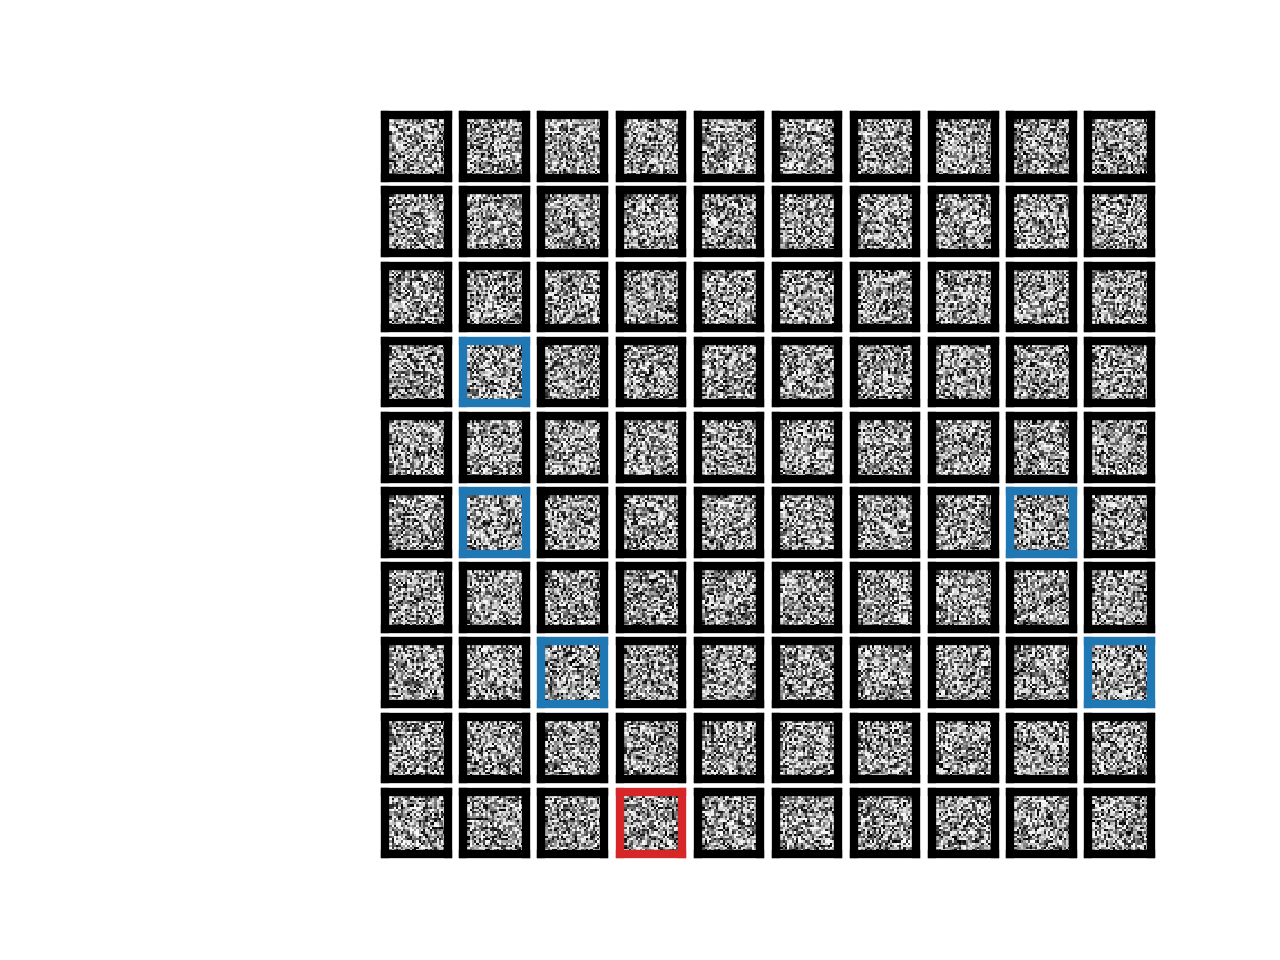

In [24]:
# plot before retraining
fig, axes = plt.subplots(nrows=10, ncols=10)
for r in range(10):
    for c in range(10):
        
        x = rand_dataloader.dataset[10*r+c][0].numpy().reshape((28,28))
        
        # is the max bigger than rest combined?
        if np.max(predictions[10*r+c])>=0.5:
            axes[r,c].spines['bottom'].set_color('tab:red')
            axes[r,c].spines['top'].set_color('tab:red')
            axes[r,c].spines['left'].set_color('tab:red')
            axes[r,c].spines['right'].set_color('tab:red')
        
        # is the max close to the min?
        if np.max(predictions[10*r+c])<=0.2:            
            axes[r,c].spines['bottom'].set_color('tab:blue')
            axes[r,c].spines['top'].set_color('tab:blue')
            axes[r,c].spines['left'].set_color('tab:blue')
            axes[r,c].spines['right'].set_color('tab:blue')
            
        axes[r,c].spines['bottom'].set_linewidth(3)
        axes[r,c].spines['top'].set_linewidth(3)
        axes[r,c].spines['left'].set_linewidth(3)
        axes[r,c].spines['right'].set_linewidth(3)
        axes[r,c].tick_params(axis='both', labelbottom='off', labelleft='off', bottom='off', left='off')

        axes[r,c].imshow(x, cmap=plt.cm.get_cmap('Greys'))
#         axes[r,c].axis('off')
plt.subplots_adjust(left=0.3, hspace=0.2)
plt.show()

In [25]:
### retrain the converted model
# expected: sigma to shrink

In [26]:
# MNIST dataset and dataloader declaration
# transforms does both the conversion from 0-255 to 0-1
# and normalizes by the precomputed mean and std

batch_size = 32

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST-dataset', train=True, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST-dataset', train=False, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=False)

In [27]:
# importances of the constraints
lmbda = (4.0*0.1/len(mnist_train_loader.dataset))
print(lmbda)

# loss function
def loss_func(model, output, target):
    
    # split output into pred and likelihoods
    output, neg_likelihood = output
    
    # normal NLL loss
    nll_loss = 0.0*F.nll_loss(output, target.long())
    # sum of sigma squares loss
    sig_loss = 0.0
    for p in model.modules():
        if isinstance(p, th.FGN_layer):
            sig_loss += torch.abs(p.sigs).pow(2).sum()
    sig_loss = 100.0*lmbda*sig_loss
    
    nllg_loss = 0.0*lmbda*torch.sum(neg_likelihood)

    return nll_loss + sig_loss + nllg_loss

6.66666666667e-06


In [28]:
# number of correct pred function for fgnet
def fgn_pred_func(output, target):
    output,_ = output
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.long().view_as(pred)).sum().item()
    return correct

In [29]:
# model_optimizer
optimizer = optim.SGD(filter(lambda p: p.requires_grad, fgn_model.parameters()), lr=0.01, momentum=0.5, nesterov=True)

In [30]:
# pre-training acc
fgn_test_res = th.test(fgn_model, device, mnist_test_loader, loss_func=loss_func, verbose=True, pred_func=fgn_pred_func)

Test set - Average loss: 2.7030, Accuracy: 9559/10000 (96%)


In [31]:
# # retrain
# epochs = 3
# train_res = th.train(fgn_model, device, mnist_train_loader, loss_func, optimizer, epochs, save_hist=2, verbose=True, pred_func=fgn_pred_func, test_loader=mnist_test_loader)

In [32]:
# compare models performance over MNIST
# post-training acc
fgn_test_res = th.test(fgn_model, device, mnist_test_loader, loss_func=loss_func, verbose=True, pred_func=fgn_pred_func)

Test set - Average loss: 2.7030, Accuracy: 9559/10000 (96%)


In [33]:
# # check that sigma has shrunk
# # plot sigma history
# for k in train_res['histories'].keys():
#     if 'sigs' in k:
#         for i in range(len(train_res['histories'][k][0])):
#             plt.plot(train_res['histories'][k][:,i], marker='.', linestyle=' ')
# #         plt.grid()
#         plt.show()

In [34]:
# MNIST dataset and dataloader declaration
# transforms does both the conversion from 0-255 to 0-1
# and normalizes by the precomputed mean and std

batch_size = 32

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST-dataset', train=True, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST-dataset', train=False, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=False)

In [35]:
# nll loss function
def classic_nll_loss_func(model, output, target):
    return F.nll_loss(output, target)

In [36]:
# nll loss function
def fgn_nll_loss_func(model, output, target):
    # split output into pred and likelihoods
    output, likelihood = output
    return F.nll_loss(output, target)    

In [37]:
# number of correct pred function for classic net
def classic_pred_func(output, target):
    output = output
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.long().view_as(pred)).sum().item()
    return correct

In [38]:
# number of correct pred function for fgnet
def fgn_pred_func(output, target):
    output,_ = output
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.long().view_as(pred)).sum().item()
    return correct

In [39]:
classic_test_res = th.test(classic_model, device, mnist_test_loader, loss_func=classic_nll_loss_func, verbose=True, pred_func=classic_pred_func)

Test set - Average loss: 0.0032, Accuracy: 9681/10000 (97%)


In [40]:
fgn_test_res = th.test(fgn_model, device, mnist_test_loader, loss_func=fgn_nll_loss_func, verbose=True, pred_func=fgn_pred_func)

Test set - Average loss: 0.0378, Accuracy: 9559/10000 (96%)


In [41]:
### Part 2 - Test all the pre-trained models
import os

all_model_paths = sorted([file for file in os.listdir(model_dir) if file.endswith("_full.pth")])
networks_sizes = [[], [8], [128], [1024], [8,8], [128,128], [1024,1024], [8,8,8], [128,128,128], [1024,1024,1024]]

In [42]:
# results will be of the form:
# {model_name: res} with res being a list with the predictions for each class
results_dict = {}

for size in networks_sizes:
    for exp_num in range(12):
        
        # dict load
        classic_model = th.Classic_MNIST_Net(hidden_l_nums=size)
        classic_model.to(device)
        classic_model.load_state_dict(torch.load(model_dir+'/model_'+str(size)+'_exp_'+str(exp_num)+'_state_dict.pth'))

        # create model to be converted
        fgn_model = th.Feedforward_FGN_net(28*28,10,size)
        
        # convert 
        # convert the model
        classic_list = build_lin_layer_state_dicts(classic_model.state_dict())
        fgn_list = build_fgn_layer_state_dicts(fgn_model.state_dict())

        new_state_dict = OrderedDict()
        for c, f in zip (classic_list, fgn_list):
            new_state_dict.update(convert_state_dict_lin2FGN(c,f))
        
        fgn_model.load_state_dict(new_state_dict)
        fgn_model.to(device)
            
        # apply model to data
        # get predictions 
        predictions = np.array([])
        for data in rand_dataloader:
            data = data[0].to(device)
            pred,_ = fgn_model(data)
            pred = pred.cpu().detach().numpy()
            try:
                predictions = np.concatenate((predictions,pred))
            except:
                predictions=pred        

        # for some reason the networks make log_softmax predictions
        predictions = np.exp(predictions)

        # we really only care about the max
        maxes = [np.max(p) for p in predictions]

        # add to dict
        results_dict['model_'+str(size)+'_exp_'+str(exp_num)] = maxes

In [43]:
from scipy.stats import describe
maxes_test = results_dict["model_[8, 8]_exp_1"]
print("Min of maxes:", np.min(maxes_test))
print(describe(maxes_test))

Min of maxes: 0.12285761
DescribeResult(nobs=10000, minmax=(0.12285761, 0.122910574), mean=0.122910276, variance=1.1833783e-12, skewness=-30.78583335876465, kurtosis=1222.3376553810954)


<IPython.core.display.Javascript object>


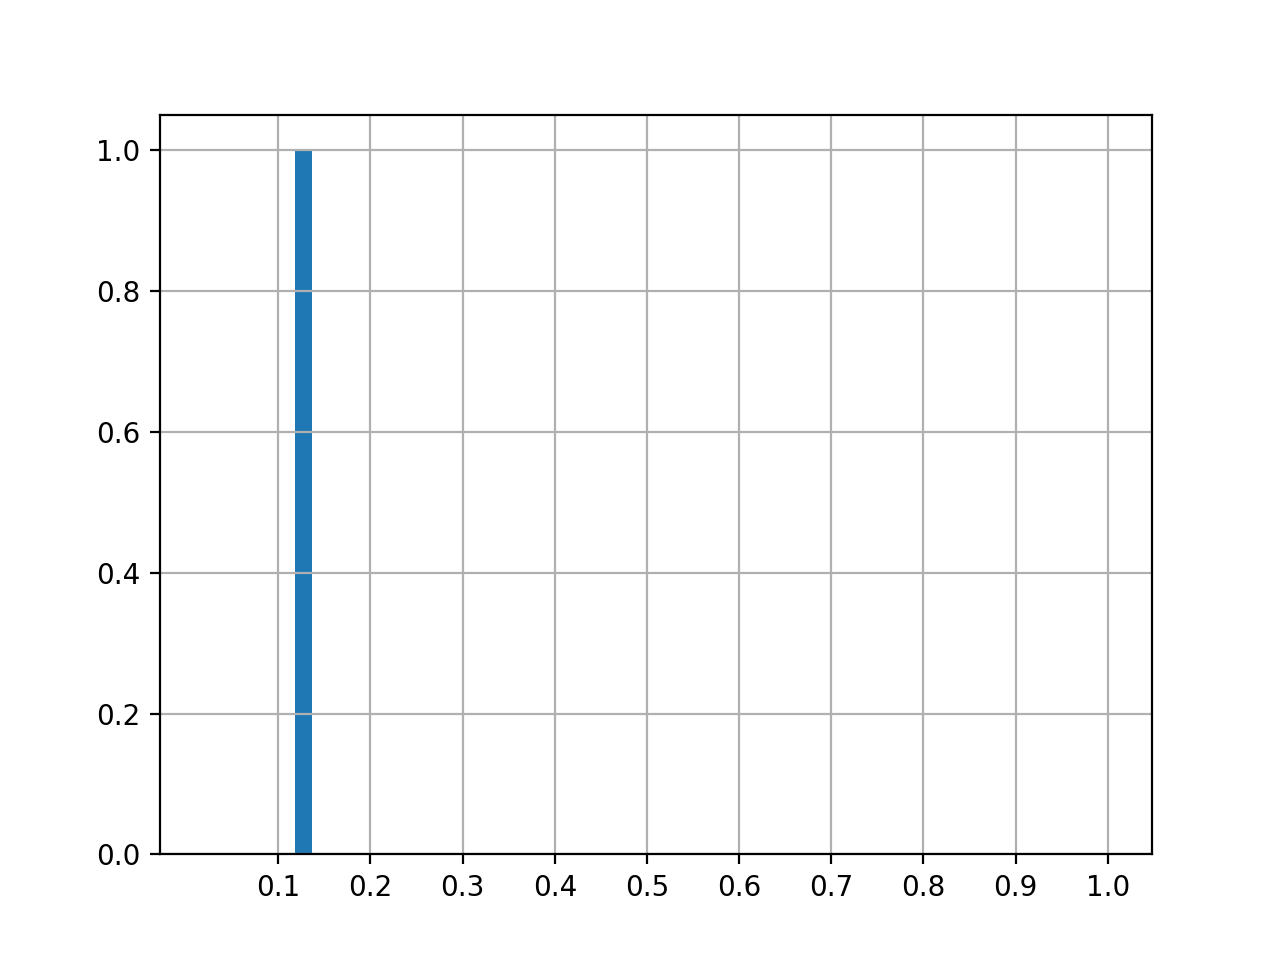

In [44]:
weights = np.ones_like(maxes_test)/len(maxes_test)
plt.hist(maxes_test, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.show()

Network size []


<IPython.core.display.Javascript object>


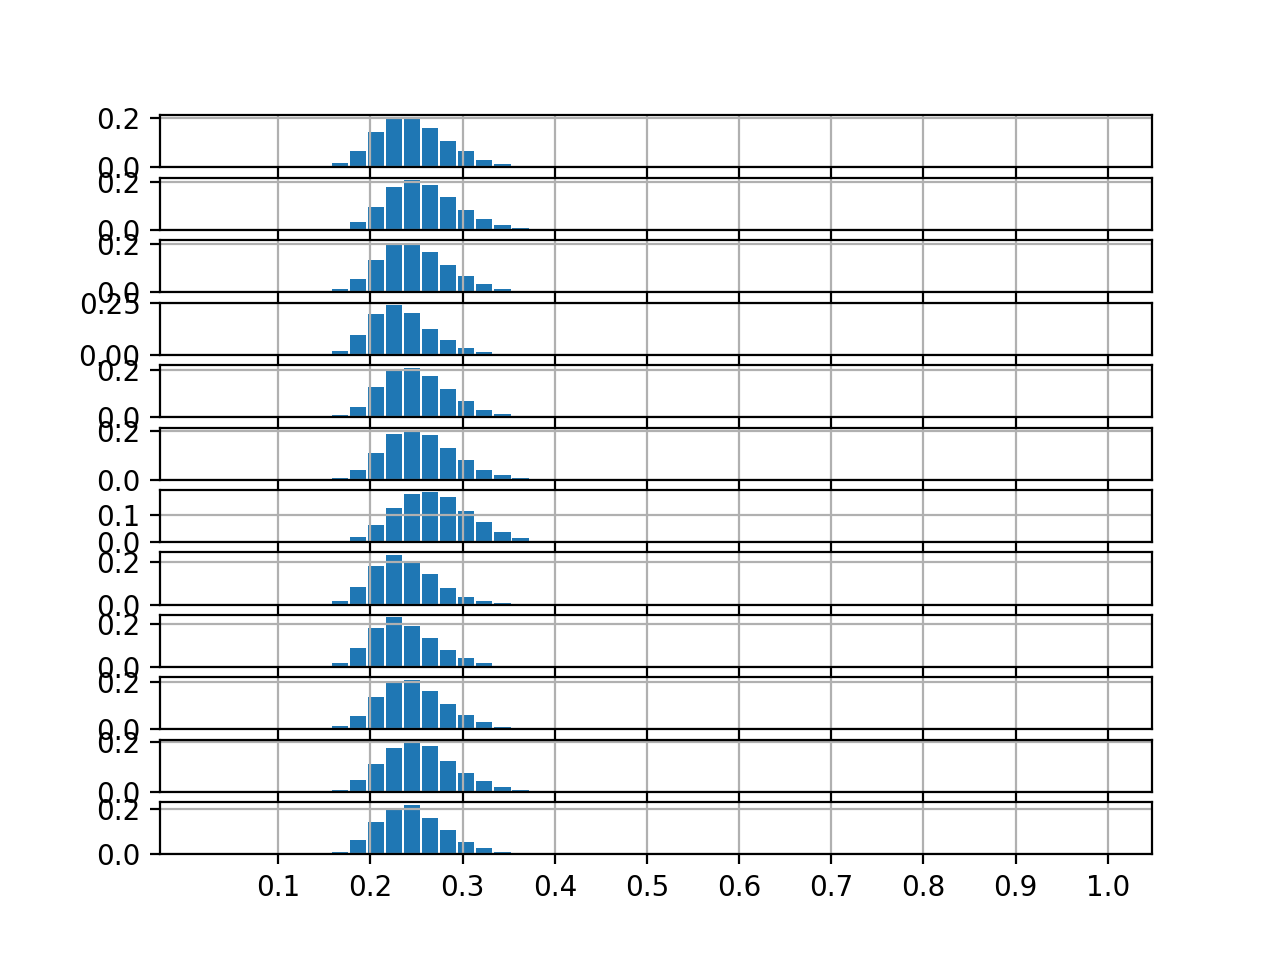

Network size [8]


<IPython.core.display.Javascript object>


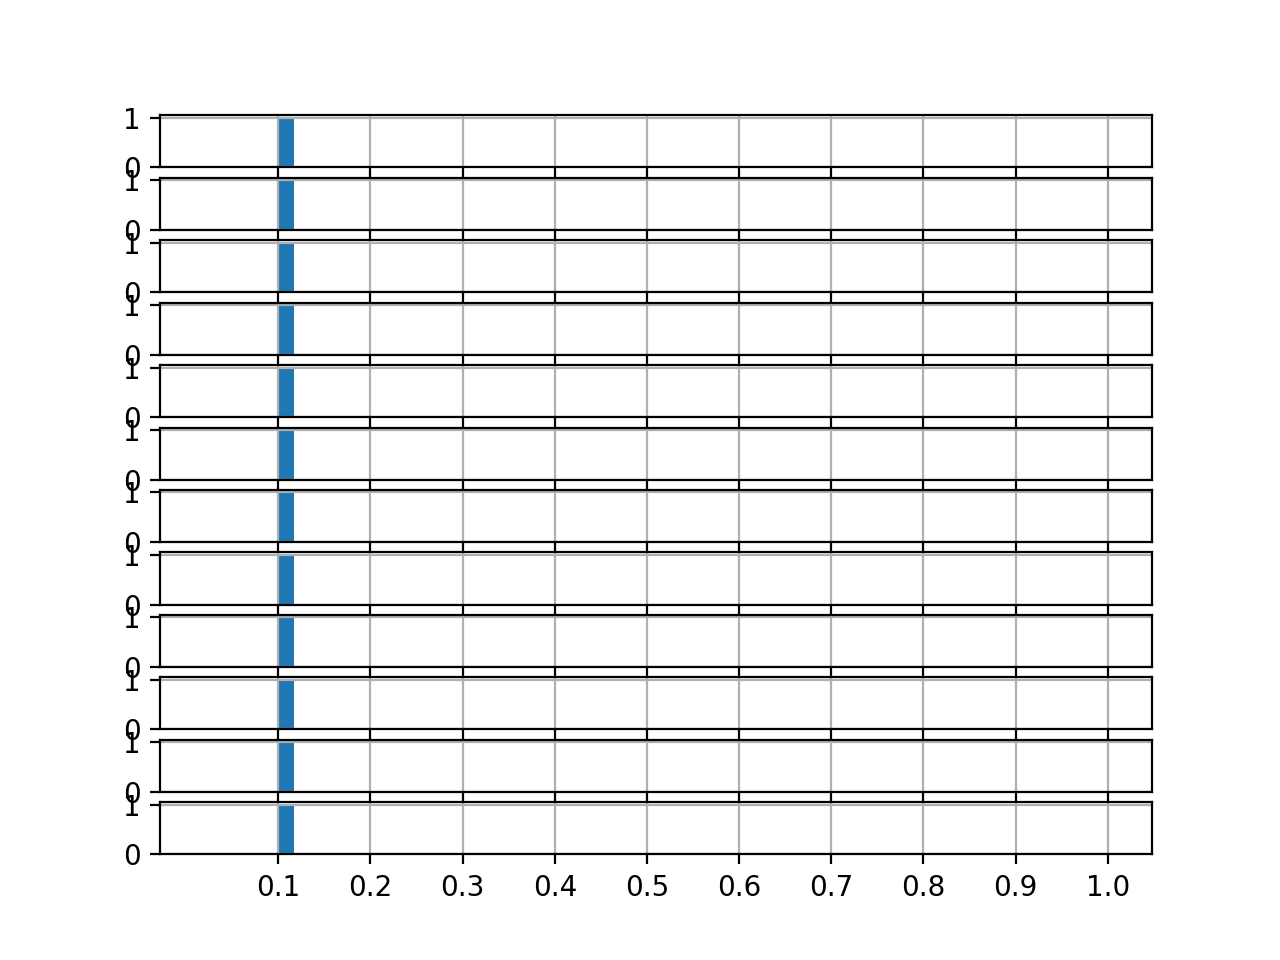

Network size [128]


<IPython.core.display.Javascript object>


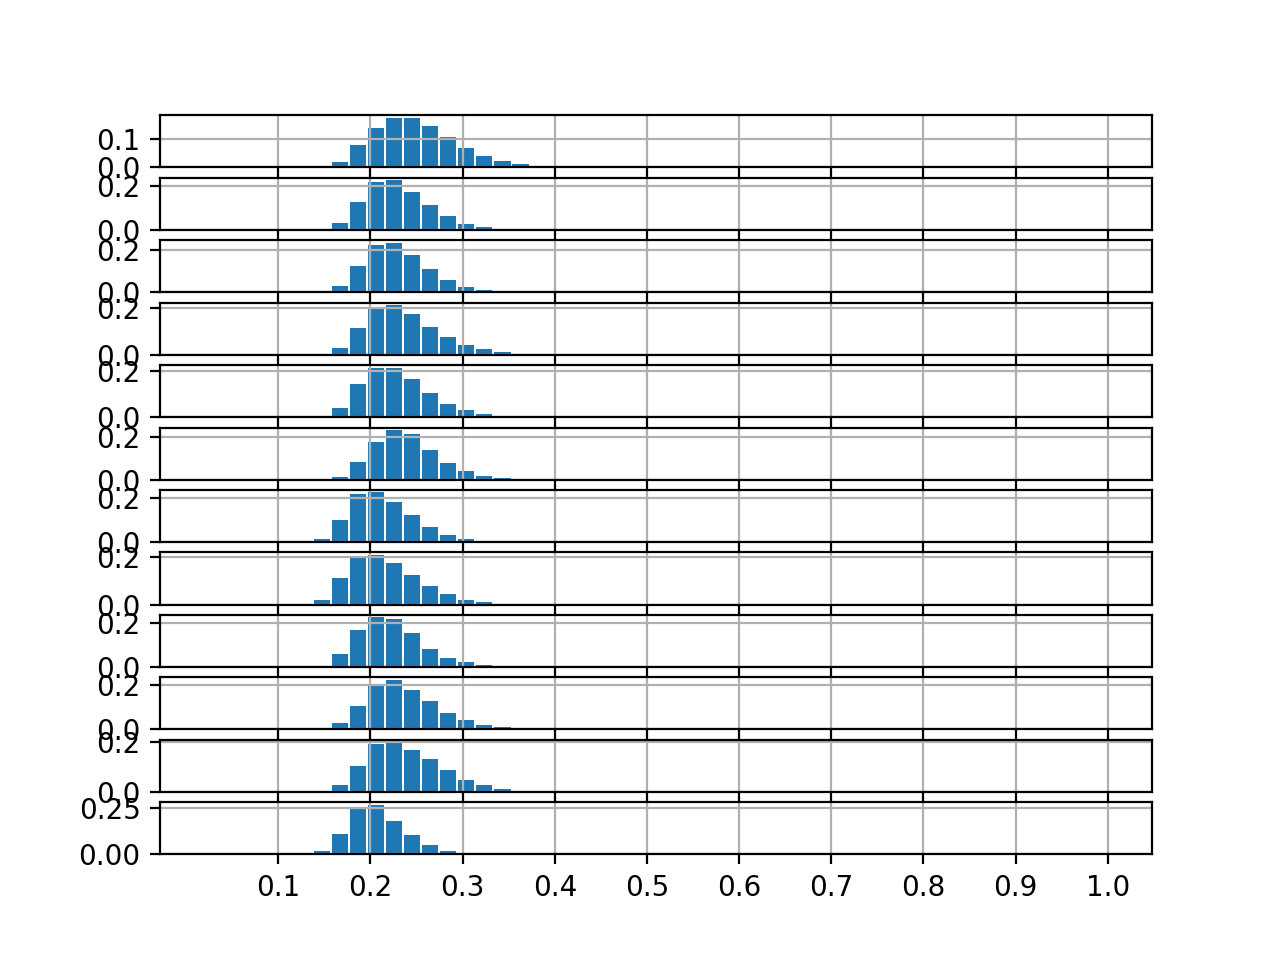

Network size [1024]


<IPython.core.display.Javascript object>


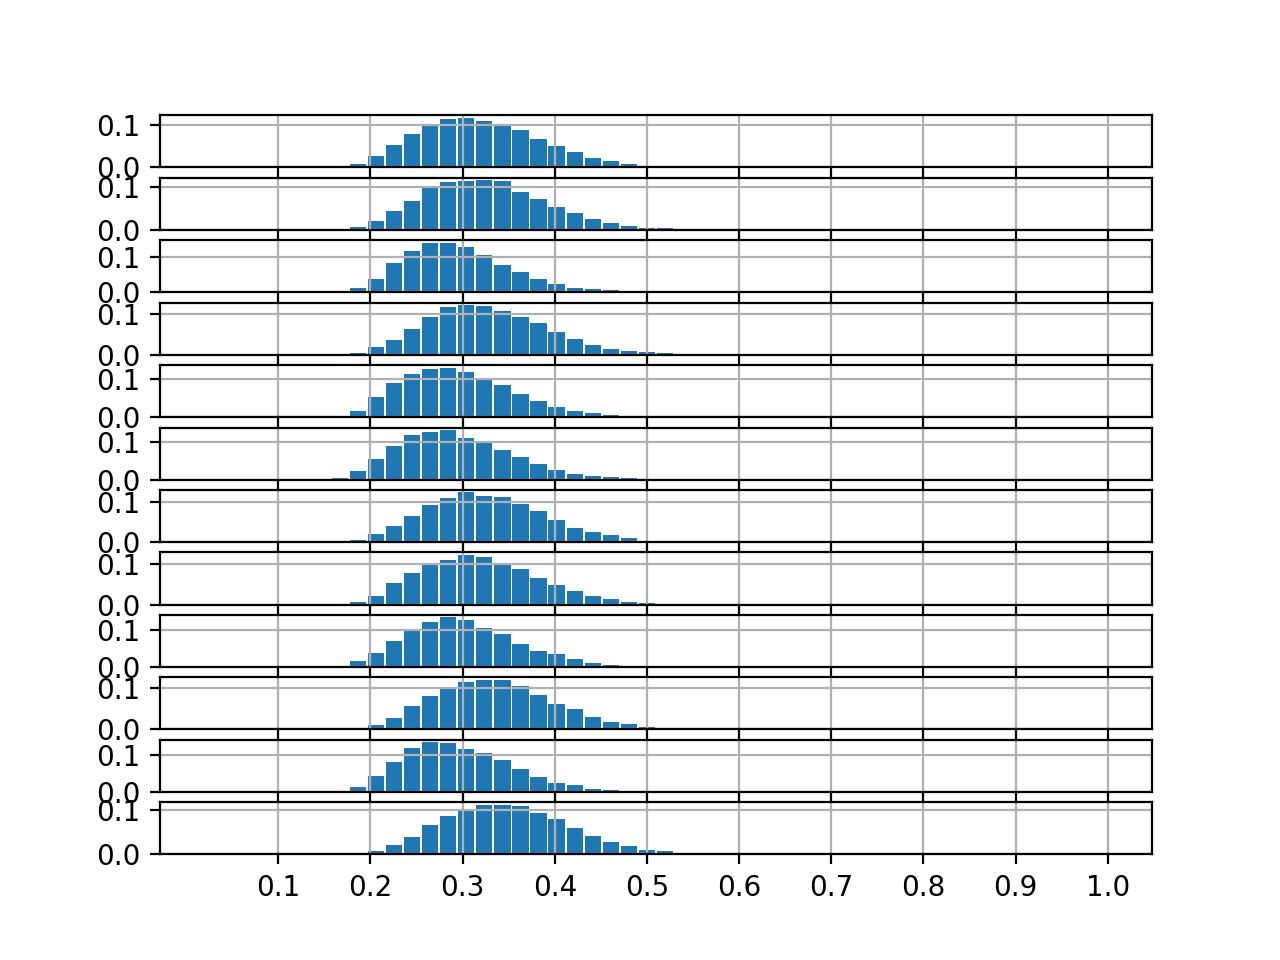

Network size [8, 8]


<IPython.core.display.Javascript object>


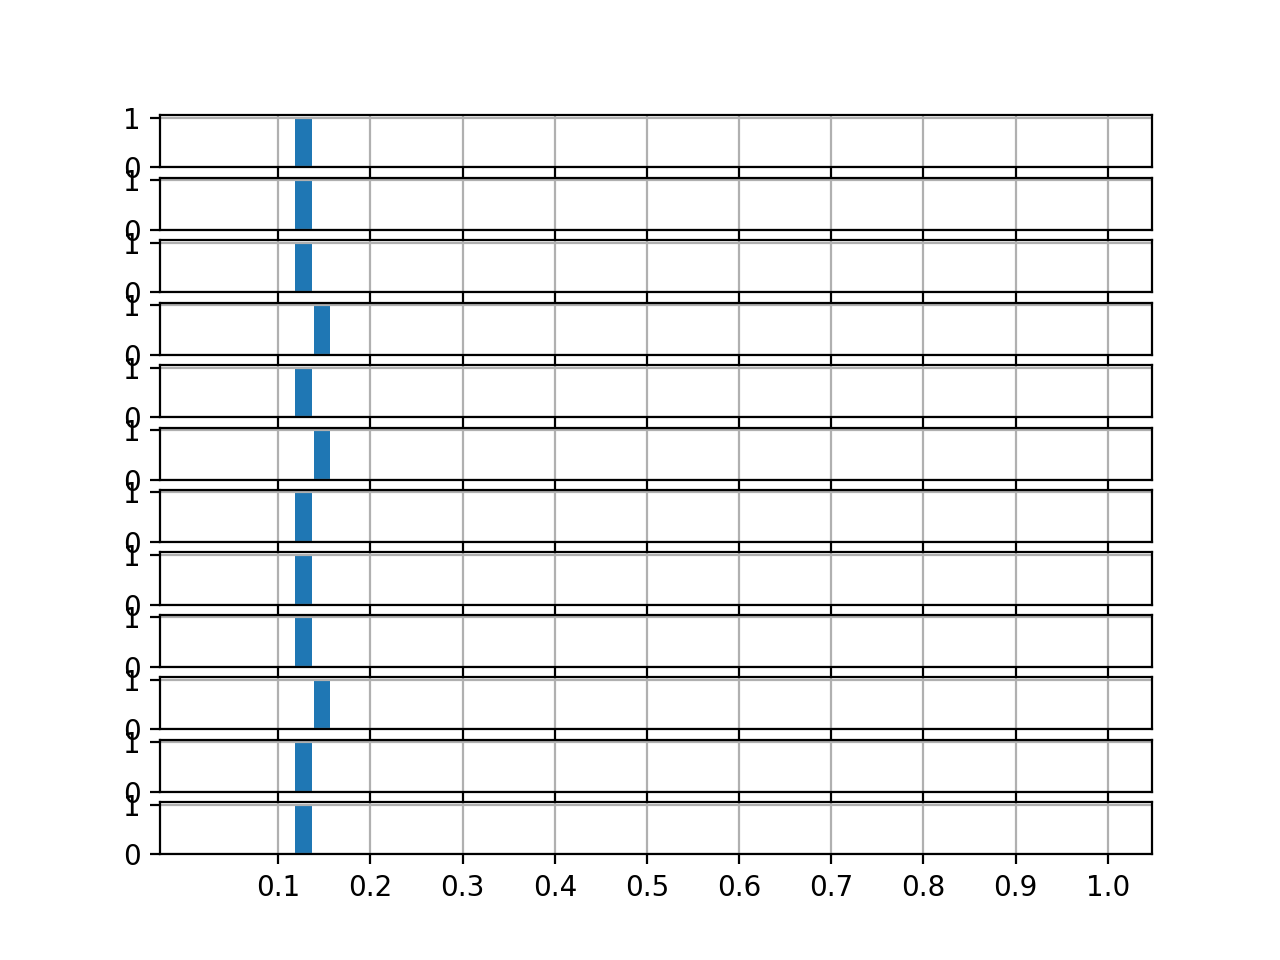

Network size [128, 128]


<IPython.core.display.Javascript object>


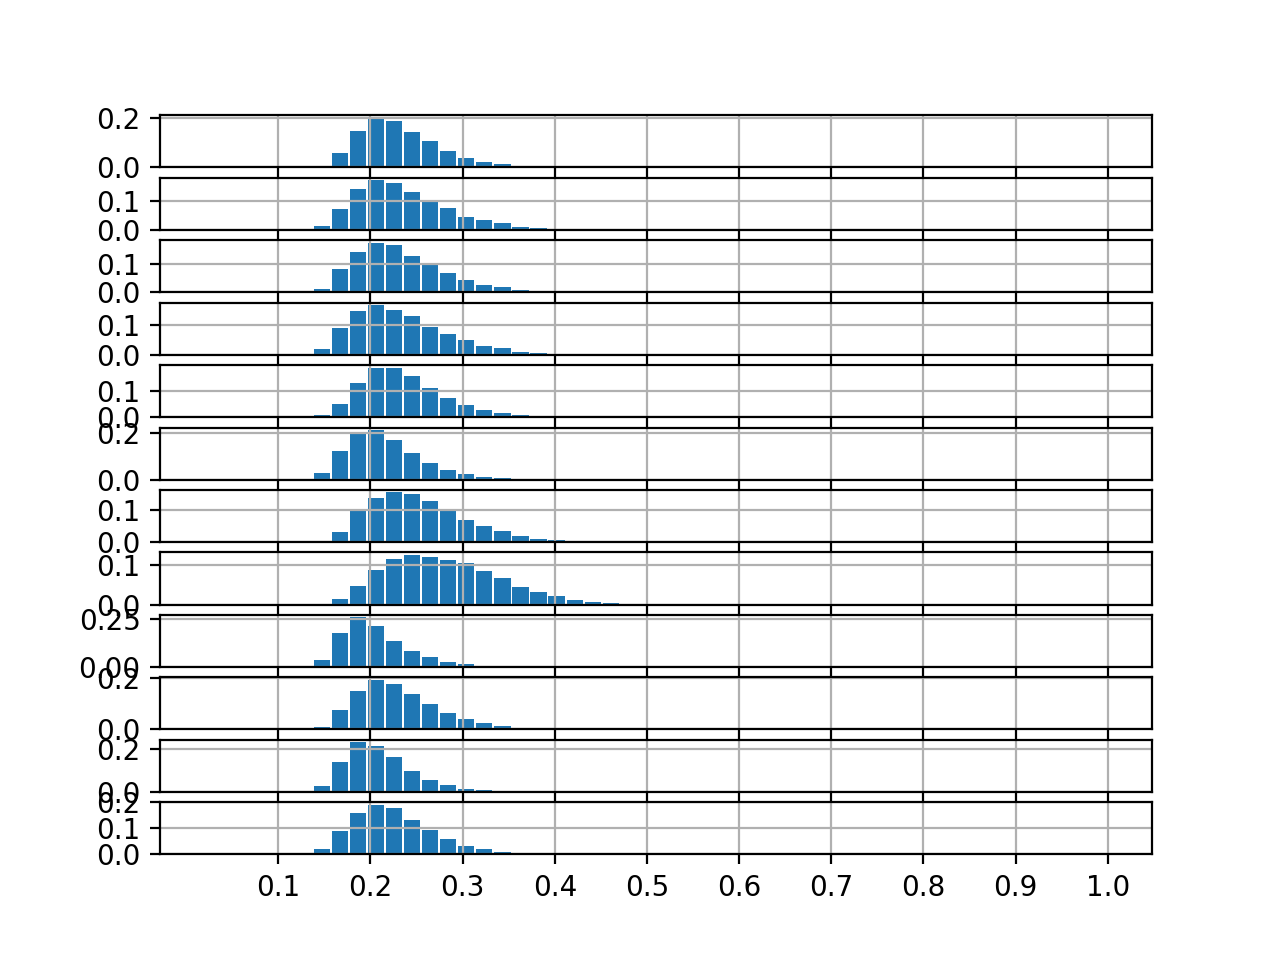

Network size [1024, 1024]


<IPython.core.display.Javascript object>


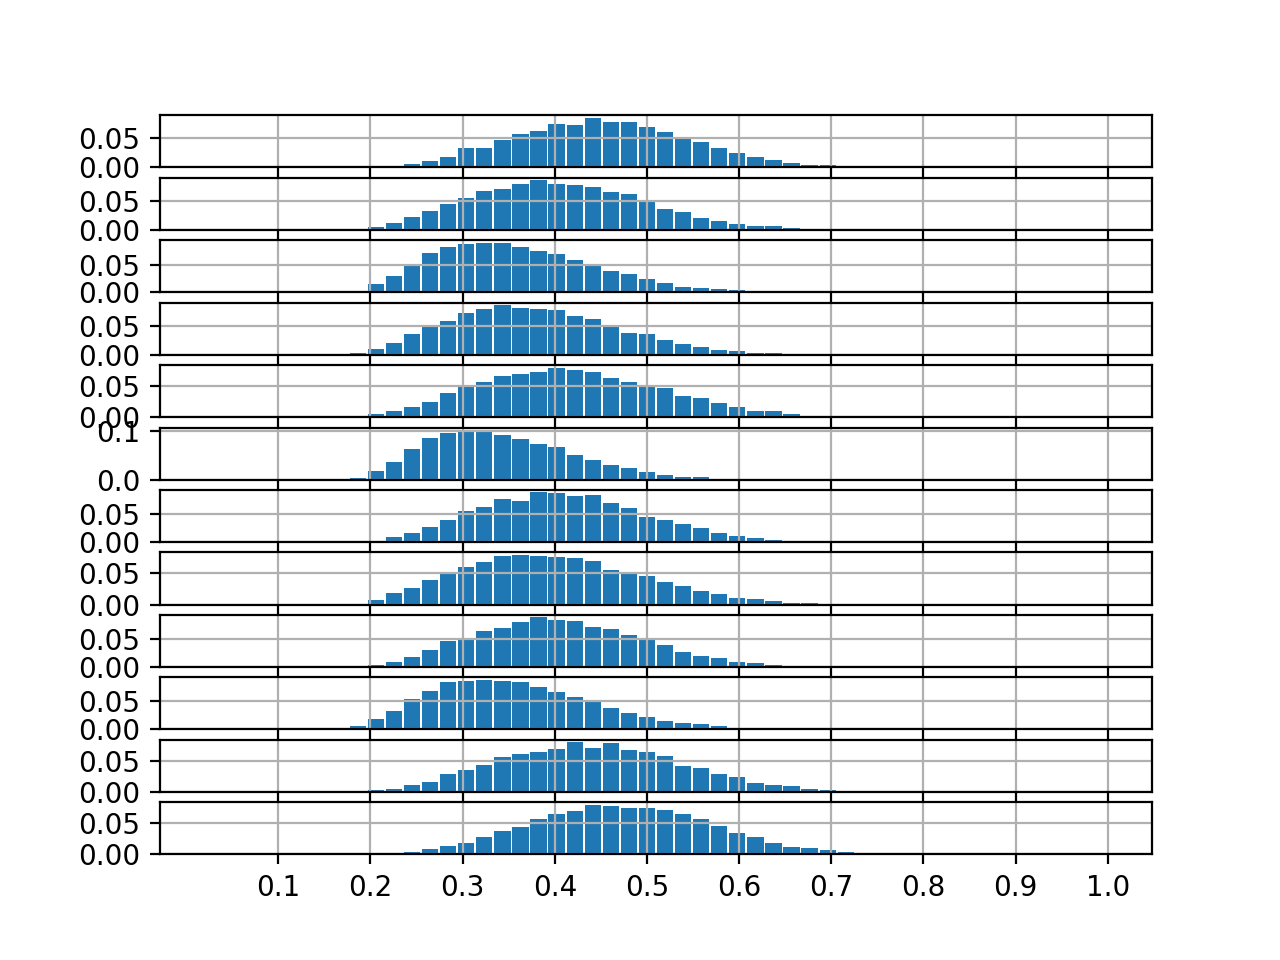

Network size [8, 8, 8]


<IPython.core.display.Javascript object>


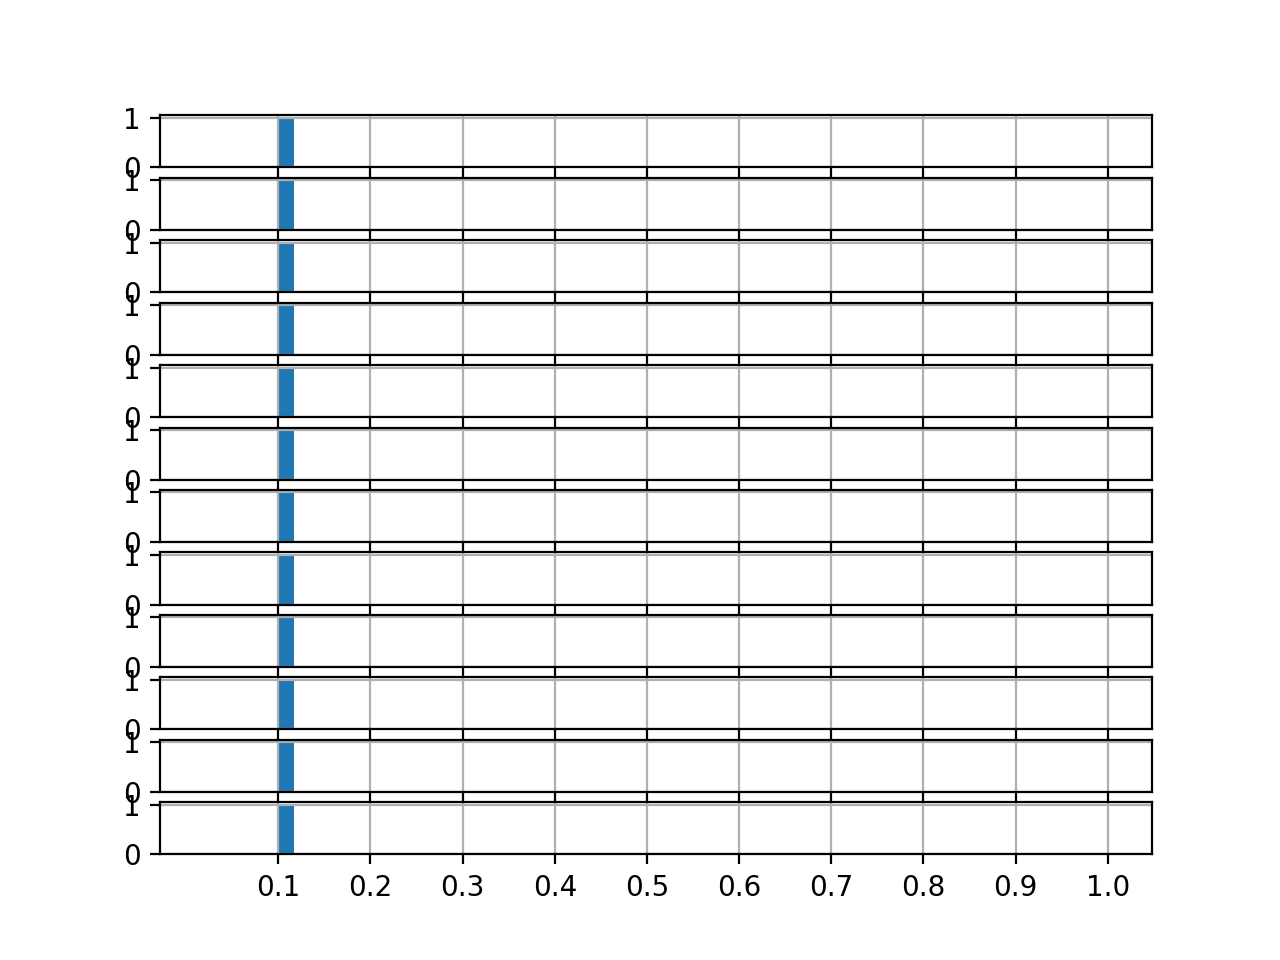

Network size [128, 128, 128]


<IPython.core.display.Javascript object>


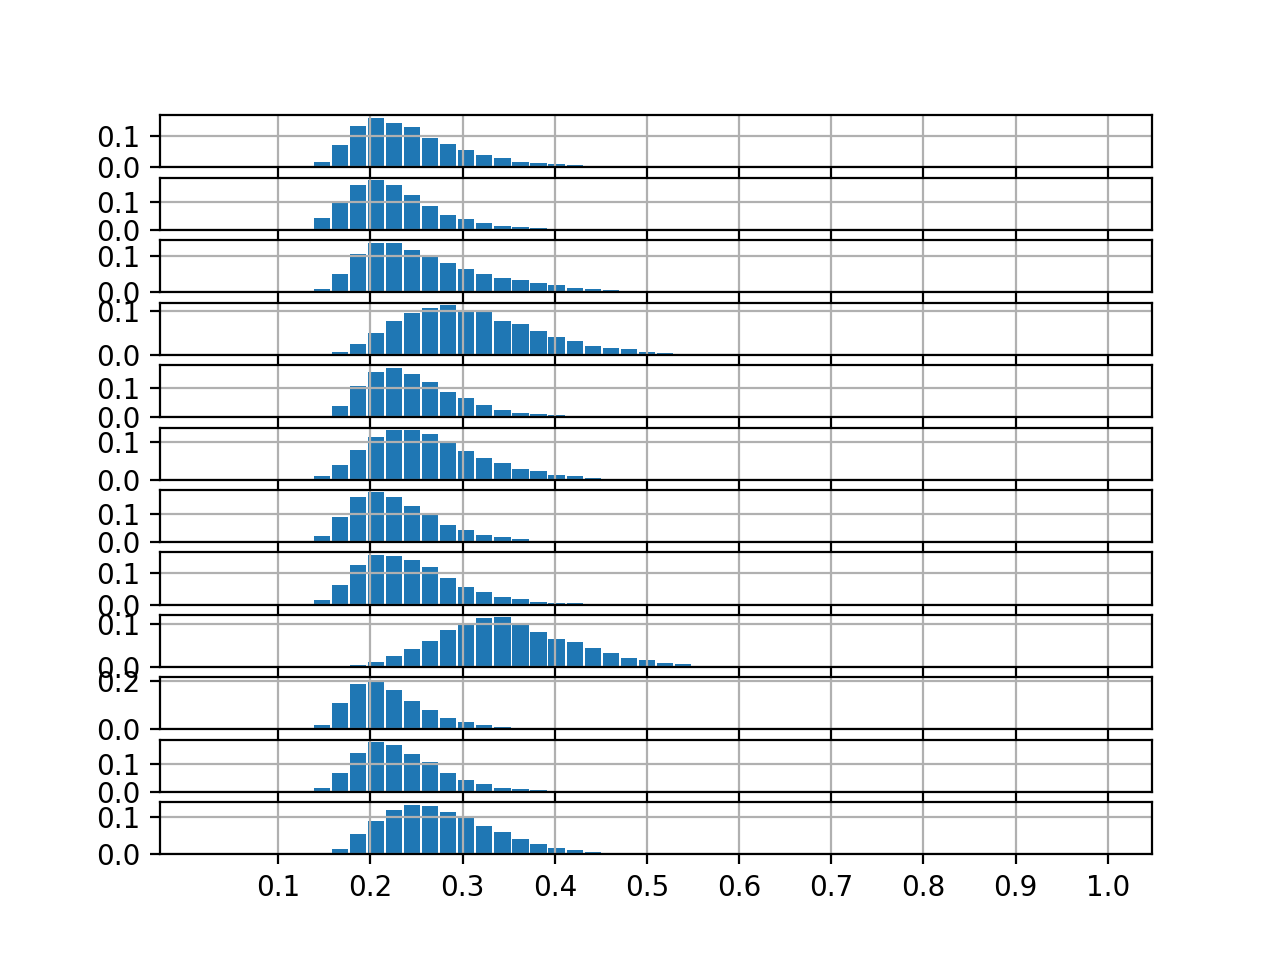

Network size [1024, 1024, 1024]


<IPython.core.display.Javascript object>


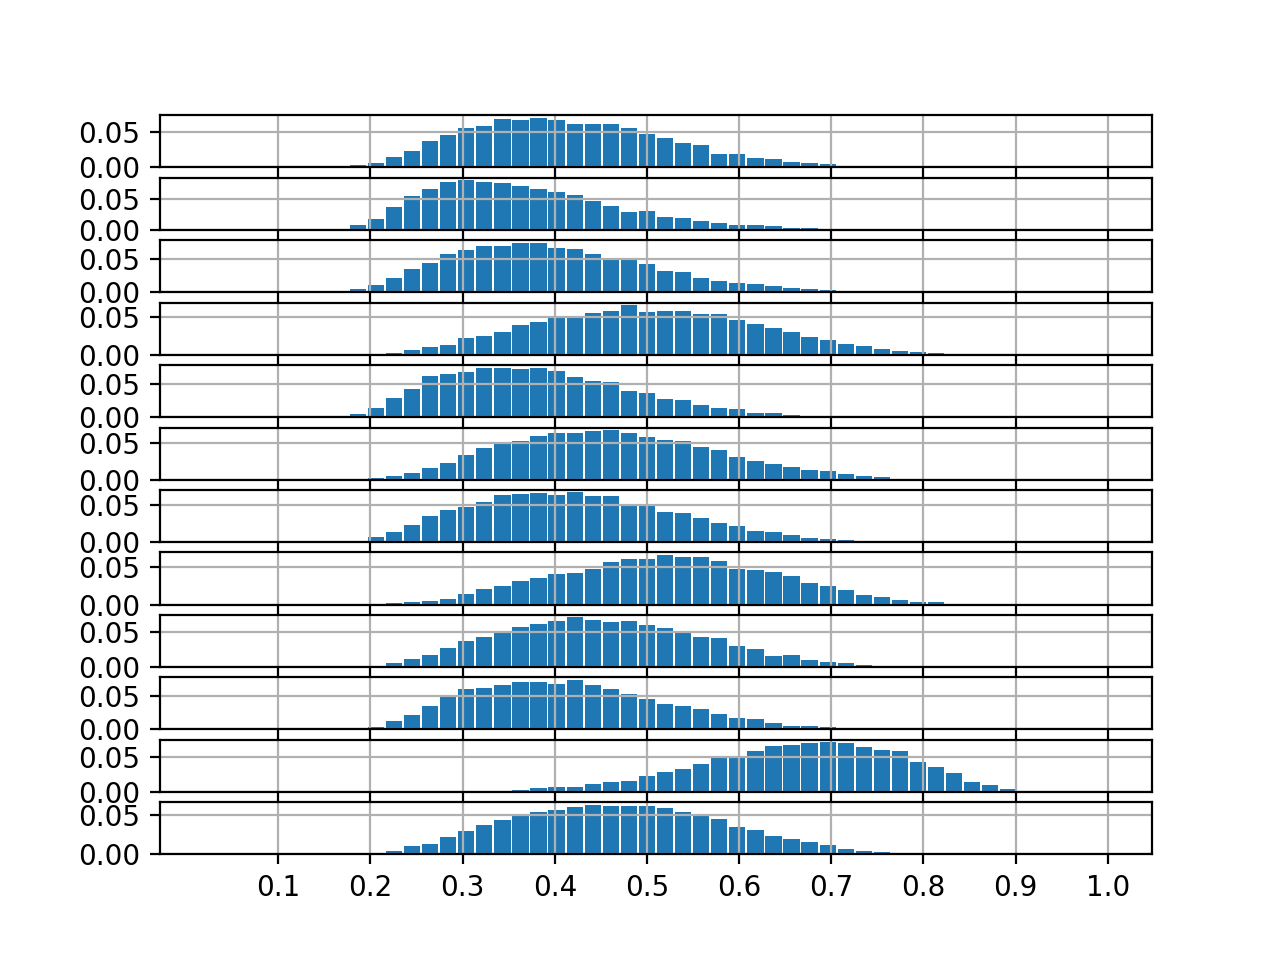

In [45]:
# plot the histogram for each model

for size in networks_sizes:
    print("Network size", size)
    subplot_num = 0
    for k in results_dict.keys():
        if str(size) in k:
            subplot_num += 1
            axe = plt.subplot(12,1, subplot_num)
            axe.hist(results_dict[k], bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
            plt.xticks((np.arange(10)+1)/10.0)
        #     plt.yticks((np.arange(0,11,2))/10.0)
            plt.grid(True)
    plt.show()

